## Overview

This project aims to classify images of cars into their respective make and model using the **Stanford Cars Dataset**. The model is fine-tuned using a pre-trained ResNet-18 architecture to achieve high accuracy in real-world scenarios.

#### Key Objectives:
- Train and evaluate a deep learning model for car classification.
- Experiment with different hyperparameters and augmentations to improve performance.
- Deploy the model via an API for real-time usage.

#### Assumptions Made:
1. Definition of the term "Car Type":
Assumed that "car type" refers to a combination of make, model, and year rather than a broader category (e.g., sedan, SUV, etc.). This interpretation is based on the granularity of the Stanford Cars Dataset, which categorizes images at the make-model-year level.

**Reason**: Identifying the make, model, and year aligns with real-world use cases, such as law enforcement or fleet management, which often require this level of detail for identification purposes.

2. Bounding Boxes Represent the Car:
Assumed that the bounding boxes provided in the dataset encompass the car entirely and do not exclude significant parts of the vehicle (e.g., front or rear sections).Sample checks were done but there were too many images to check through

**Reason**: The effectiveness of cropping and model training relies on these bounding boxes being accurate and complete.

#### <ins>Dataset Overview</ins>

The **Stanford Cars Dataset** contains 16,185 images across 196 car classes. Each image is annotated with a bounding box and class label.

- **Training Set:** 8,144 images

- **Testing Set:** 8,041 images

- **Classes:** 196 distinct car models

- **Annotations:** Bounding box coordinates for each image


## Table of Content:
* [Introduction and Setup](#first-bullet)

* [Exploratory Data Analysis](#second-bullet)

* [Image Processing](#third-bullet)

* [Model Training and Validation](#fourth-bullet)

* [Results](#fifth-bullet)


## Introduction and Setup <a class="anchor" id="first-bullet"></a>
1) Import the relevant libraries

2) Load the Configuration Settings via the config.yaml file. This will extract the following configurations
    - Experiment Parameters
    - Early Stopping Parameters
    - Artifacts save paths

3) Load the Stanford Cars Dataset. It consist of 2 files, the image files and annotation file.
    - Each image includes:
        - Pictures of various cars
    
    - Each annotation includes:
        - Bounding box (bbox_x1, bbox_y1, bbox_x2, bbox_y2).
        - Class label (1–196).
        - File name (e.g., "00001.jpg").  

    - cars_meta.mat contains a list of car class names (196 in total).

4) Preview some of the images with the respective bounding boxes

In [3]:
# Standard Libraries
import os
import json
from pathlib import Path
from multiprocessing import set_start_method
import numpy as np
from scipy.io import loadmat
import yaml
from pathlib import Path

# Data Handling and Analysis
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm.notebook import tqdm

# Image Handling and Augmentation
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms.functional import to_pil_image

# PyTorch (Deep Learning Framework)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Experiment Tracking and Utilities
import mlflow
from utils.image_processing import (
    detect_and_blur_license_plate, 
    parse_annotations,
    crop_and_save_images,
    display_cropped_images,
    stratified_split,
    get_augmentation_pipelines,
    StanfordCarsDataset
)
from utils.image_analysis import (
    extract_image_dimensions,
    plot_image_dimension_distributions,
    calculate_bounding_box_stats_with_actual_dimensions,
    plot_bounding_box_distributions,
    plot_samples_with_bboxes,
    parse_annotations_to_dataframe,
    analyze_class_distribution,
    visualize_low_ratio_images
)

from utils.model_training import (
    initialize_model,
    plot_learning_curves
)
# IPython (for Notebook Settings)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Miscellaneous
torch.multiprocessing.set_start_method("fork", force=True)



In [4]:
# Load config.yaml
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)


# Extract experiment parameters
experiment_name = config["experiment"]["experiment_name"]
architecture_description = config["experiment"]["architecture_description"]
batch_size = config["experiment"]["batch_size"]
learning_rate = config["experiment"]["learning_rate"]
dropout = config["experiment"]["dropout"]
num_epochs = config["experiment"]["num_epochs"]
weight_decay = config["experiment"]["weight_decay"]
enable_plate_detection = config["experiment"]["enable_plate_detection"]
use_augmentation = config["experiment"]["use_augmentation"]

# Extract early stopping parameters
patience = config["early_stopping"]["patience"]
min_delta = config["early_stopping"]["min_delta"]

# Extract save paths
class_names_file = Path(config["save_paths"]["class_names_file"])
learning_curves_path = Path(config["save_paths"]["learning_curves"])
model_save_path = Path(config["save_paths"]["model_save_path"])
confusion_metrics_path = Path(config["save_paths"]["confusion_metrics_path"])
test_metrics_path = Path(config["save_paths"]["test_metrics_path"])

In [5]:
# Constants for dataset paths
DATA_DIR = Path("data/raw/stanford-cars-dataset")
META_DIR = Path("data/raw/standford-cars-dataset-meta")

# Subdirectories
CARS_TEST_DIR = DATA_DIR / "cars_test/cars_test"
CARS_TRAIN_DIR = DATA_DIR / "cars_train/cars_train"

# Metadata files
CARS_ANNOS_TRAIN = META_DIR / "devkit/cars_train_annos.mat"
CARS_ANNOS_TEST = META_DIR / "cars_test_annos_withlabels (1).mat"
CARS_META_FILE = META_DIR / "devkit/cars_meta.mat"

# Processed data paths
CROPPED_TRAIN_DIR = Path("data/processed/cropped_train")
CROPPED_TEST_DIR = Path("data/processed/cropped_test")

In [6]:

# Directories and metadata
cars_test = CARS_TEST_DIR
cars_train = CARS_TRAIN_DIR

cars_annos_train = CARS_ANNOS_TRAIN
cars_annos_test = CARS_ANNOS_TEST

cars_meta_mat = loadmat(CARS_META_FILE)
cars_annos_train_mat, cars_annos_test_mat = (
    loadmat(cars_annos_train),
    loadmat(cars_annos_test),
)
cars_annos_train_mat, cars_annos_test_mat = loadmat(cars_annos_train), loadmat(cars_annos_test) 
class_names = [arr[0] for arr in cars_meta_mat['class_names'][0]]
with open(class_names_file, "w") as f:
    json.dump(class_names, f)


# Parse training and test annotations
bounding_boxes_train, class_labels_train, file_names_train = parse_annotations(cars_annos_train_mat['annotations'][0])
bounding_boxes_test, class_labels_test, file_names_test = parse_annotations(cars_annos_test_mat['annotations'][0])


# Parse annotations into dictionaries
training_image_label_dict, testing_image_label_dict = {}, {}

for arr in cars_annos_train_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    training_image_label_dict[image] = label

for arr in cars_annos_test_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    testing_image_label_dict[image] = label


In [7]:
# Initialize MLflow experiment
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/danielmak/Documents/HTX/mlruns/461932302175787790', creation_time=1733847862345, experiment_id='461932302175787790', last_update_time=1733847862345, lifecycle_stage='active', name='ResNet18_Image_Classification', tags={}>

### Previewing some of the images from train and test set

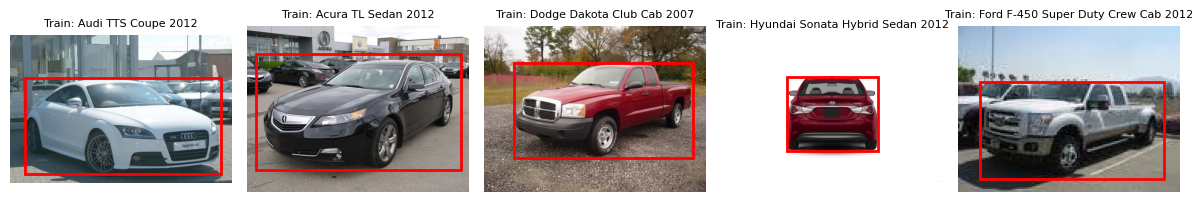

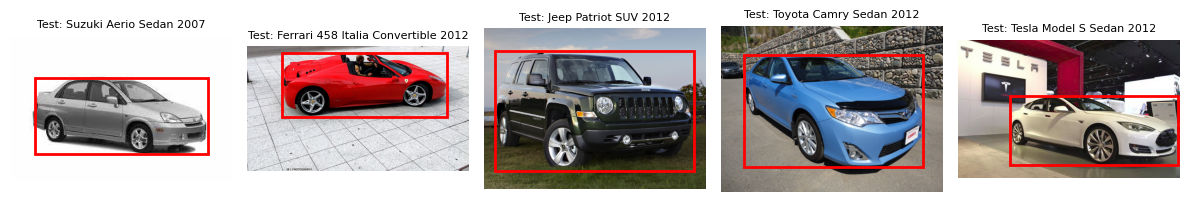

In [8]:
# Parameters
num_samples = 5  # Number of samples to display

# Plot training samples
plot_samples_with_bboxes(
    num_samples=num_samples,
    annotations=cars_annos_train_mat['annotations'][0],
    class_names=[name[0] for name in cars_meta_mat['class_names'][0]],
    cars_dir=cars_train,
    dataset_type="train"
)

# Plot test samples
plot_samples_with_bboxes(
    num_samples=num_samples,
    annotations=cars_annos_test_mat['annotations'][0],
    class_names=[name[0] for name in cars_meta_mat['class_names'][0]],
    cars_dir=cars_test,
    dataset_type="test"
)


# Exploratory Data Analysis <a class="anchor" id="second-bullet"></a>

### <ins>Class Distribution</ins>

**Observation**:
- In general, there are no serious imbalance in the datset for both Train and Test Dataset:

    - Majority ranged between 30-45.

        - GMC Savana Van 2012 having very high count at 68
        
        - Hyundai Accent Sedan 2012 and FIAT 500 Abarth 2012 having the lowest count at 24 and 28 respectively.



Top 5 Train Classes and Frequency:
class_name
GMC Savana Van 2012                         68
Chrysler 300 SRT-8 2010                     49
Mercedes-Benz 300-Class Convertible 1993    48
Mitsubishi Lancer Sedan 2012                48
Jaguar XK XKR 2012                          47
Name: count, dtype: int64
Bottom 5 Train Classes and Frequency:
class_name
Rolls-Royce Phantom Drophead Coupe Convertible 2012    31
Chevrolet Express Cargo Van 2007                       30
Maybach Landaulet Convertible 2012                     29
FIAT 500 Abarth 2012                                   28
Hyundai Accent Sedan 2012                              24
Name: count, dtype: int64


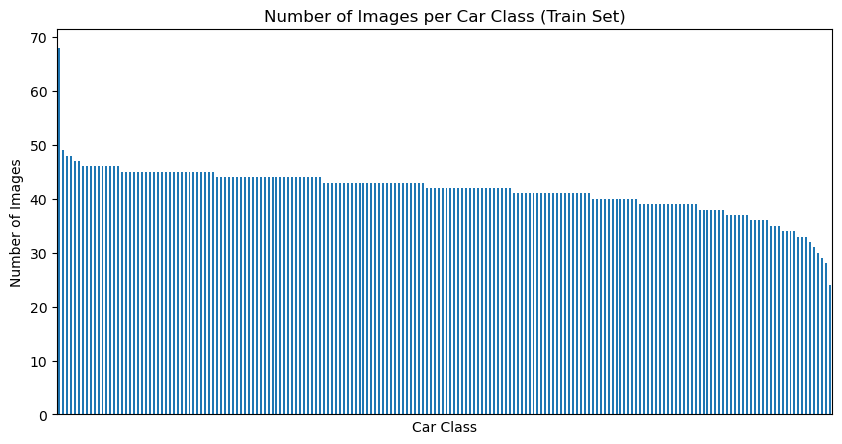

Top 5 Test Classes and Frequency:
class_name
GMC Savana Van 2012                         68
Mercedes-Benz 300-Class Convertible 1993    48
Chrysler 300 SRT-8 2010                     48
Mitsubishi Lancer Sedan 2012                47
Chevrolet Corvette ZR1 2012                 46
Name: count, dtype: int64
Bottom 5 Test Classes and Frequency:
class_name
Rolls-Royce Phantom Drophead Coupe Convertible 2012    30
Maybach Landaulet Convertible 2012                     29
Chevrolet Express Cargo Van 2007                       29
FIAT 500 Abarth 2012                                   27
Hyundai Accent Sedan 2012                              24
Name: count, dtype: int64


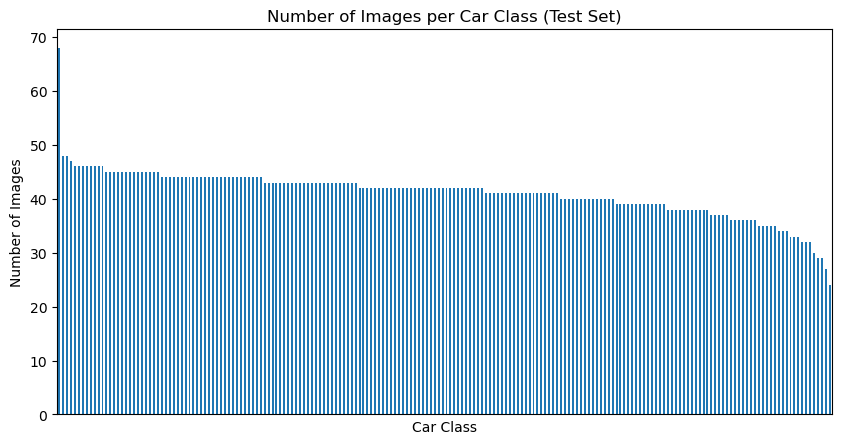

In [9]:
# Analyze training set
analyze_class_distribution(
    annotations=cars_annos_train_mat['annotations'][0],
    class_names=[name[0] for name in cars_meta_mat['class_names'][0]],
    dataset_type="train"
)

# Analyze test set
analyze_class_distribution(
    annotations=cars_annos_test_mat['annotations'][0],
    class_names=[name[0] for name in cars_meta_mat['class_names'][0]],
    dataset_type="test"
)


### <ins>Image Dimension Analysis</ins>
**Observation**:
- Both image width and length for both dataset showed a right skewed distribution, with the majority having less than 1000 pixels. 

- There are very few images that are exceptionally huge (>4000 pixels)

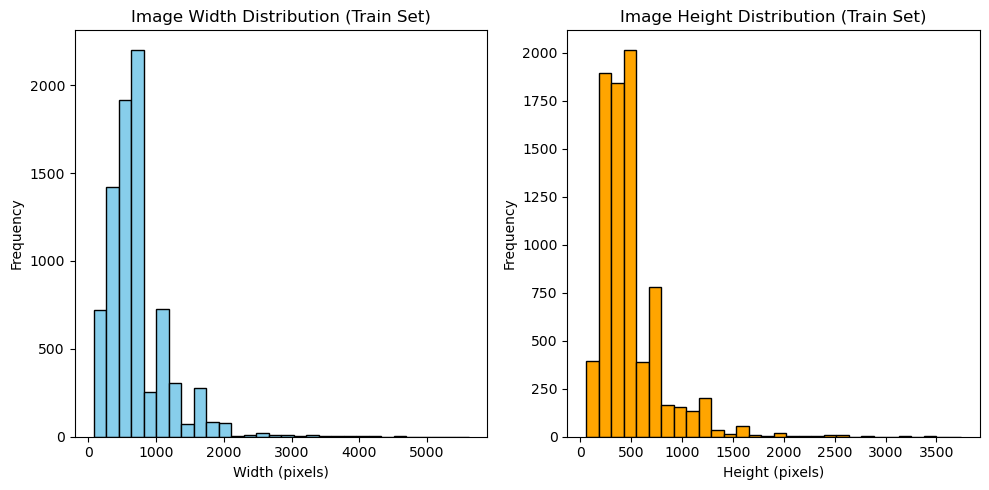

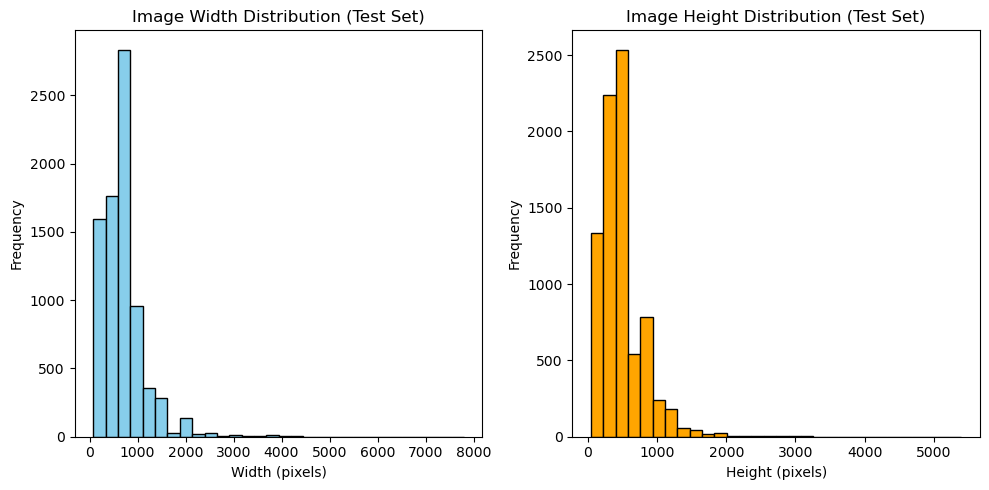

In [10]:

# Extract and plot image dimensions for train and test datasets
train_image_dimensions = extract_image_dimensions(cars_train)
test_image_dimensions = extract_image_dimensions(cars_test)

# Plot the distributions
plot_image_dimension_distributions(train_image_dimensions, dataset_type="train")
plot_image_dimension_distributions(test_image_dimensions, dataset_type="test")


### <ins>Image and Bounding Box Analysis</ins>

**Observation**:

The images in the dataset are provided with bounding box annotations. Analyzing the bounding box areas relative to the image areas reveals key insights about the dataset's composition:

##### 1. Bounding Box Area Ratio Distribution

- The bounding box area ratios is define as the **Area of Bounding Box**/ **Image Area**

- The bounding box area ratios exhibit a **bell-shaped distribution**, centered around the range **0.5 to 0.6** for both Train and Test set.

- This indicates that the bounding boxes typically occupy **50-70%** of the image area. This is a desirable characteristic as it shows the target objects (cars) occupies a reasonable proportion of the image.

##### 2. Edge cases
- A subset of images has bounding box area ratios **< 0.1** (less than 10% of the image area). Visualizing these outliers highlights issues with **excessive background** and unrelated objects. Models trained on such data might focus on **irrelevant features**, leading to poor generalization and performance.
- **Solution**:  Cropping the images based on bounding box coordinates reduces noise and ensures the model focuses on the **relevant object**.
- Resizing to Standard Dimensions (224x224) will make all cropped images. compactible with the ResNet-18 model

- However, small bounding boxes might lead to lose in details when resizing later


Average Bounding Box Area Ratio (Train): 0.5445025405740077


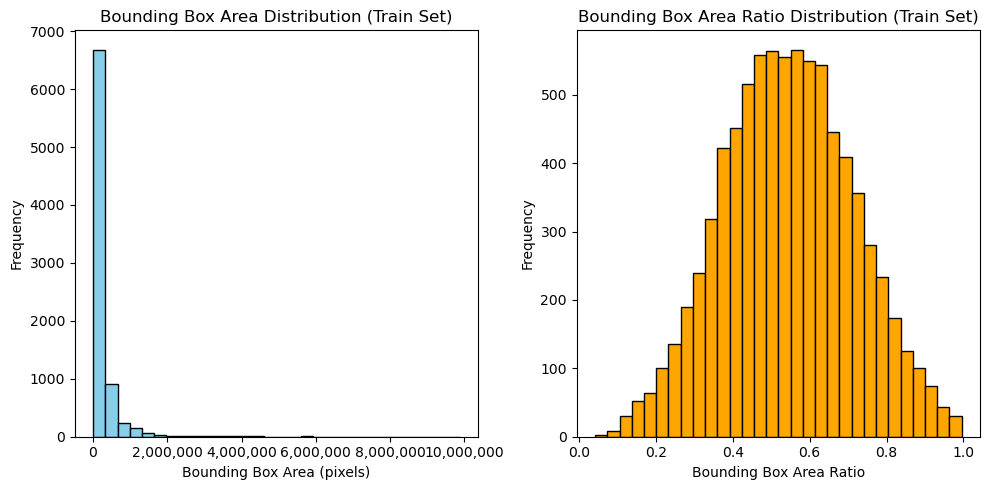

Average Bounding Box Area Ratio (Test): 0.5488241301767174


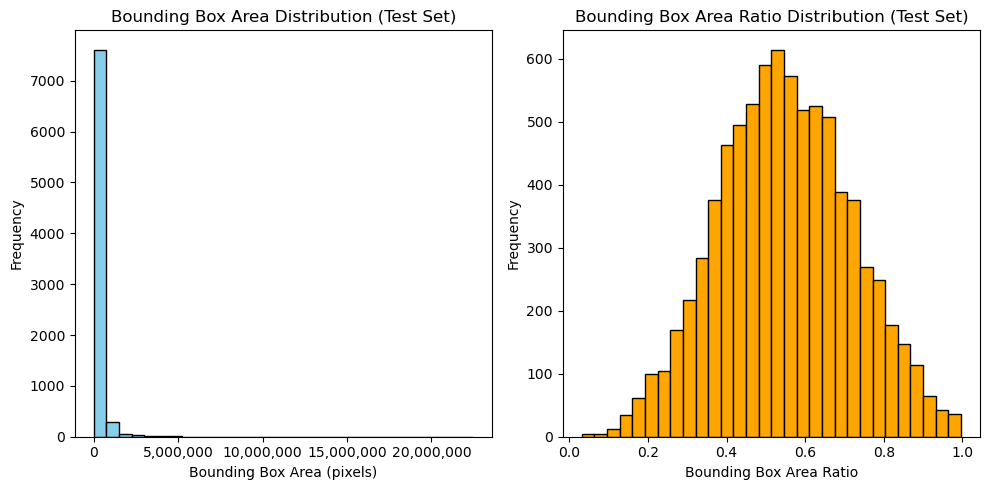

In [11]:
# Ensure to parse the train and test annotations into DataFrames
df_train, class_counts_train = parse_annotations_to_dataframe(
    annotations=cars_annos_train_mat['annotations'][0],
    class_names=[name[0] for name in cars_meta_mat['class_names'][0]]
)

df_test, class_counts_test = parse_annotations_to_dataframe(
    annotations=cars_annos_test_mat['annotations'][0],
    class_names=[name[0] for name in cars_meta_mat['class_names'][0]]
)

# Process train dataset
df_train_stats, avg_bbox_ratio_train = calculate_bounding_box_stats_with_actual_dimensions(df_train, cars_train)
print(f"Average Bounding Box Area Ratio (Train): {avg_bbox_ratio_train}")
plot_bounding_box_distributions(df_train_stats, dataset_type="train")

# Process test dataset
df_test_stats, avg_bbox_ratio_test = calculate_bounding_box_stats_with_actual_dimensions(df_test, cars_test)
print(f"Average Bounding Box Area Ratio (Test): {avg_bbox_ratio_test}")
plot_bounding_box_distributions(df_test_stats, dataset_type="test")


### <ins>Sample Images where the bounding box is very small (<0.1)</ins>

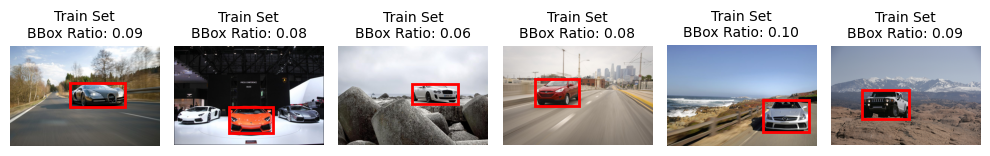

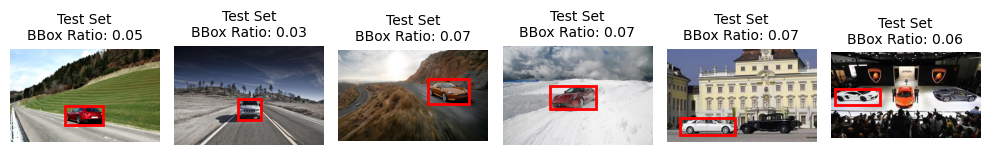

In [12]:

# Visualize images with low bounding box area ratio for the training set
visualize_low_ratio_images(
    df=df_train_stats,
    cars_dir=cars_train,
    ratio_threshold=0.1,
    num_samples=6,
    dataset_type="train"
)

# Visualize images with low bounding box area ratio for the test set
visualize_low_ratio_images(
    df=df_test_stats,
    cars_dir=cars_test,
    ratio_threshold=0.1,
    num_samples=6,
    dataset_type="test"
)


## Image Processing <a class="anchor" id="third-bullet"></a>

### Cropping the images with the bounding boxes
- The images in the dataset contain significant background elements that are unrelated to the car. Cropping ensures that the model focuses only on the target car within the bounding box, reducing noise and improving learning efficiency.

- Bounding Box information would be used for cropping

Cropped directories already exist. Skipping cropping step.


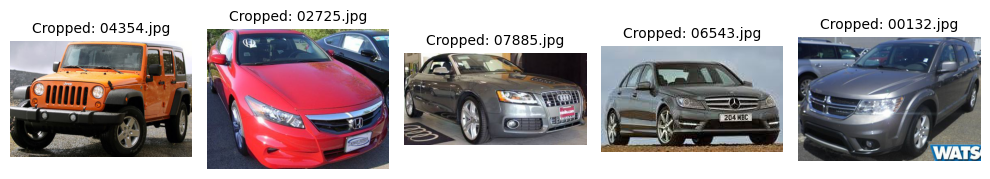

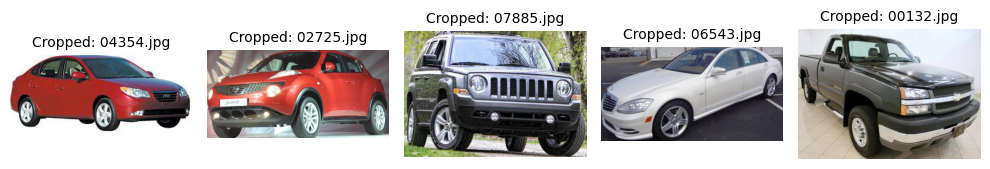

In [14]:
# Create output directories for cropped images
cropped_train_dir = Path('data/processed/cropped_train')
cropped_train_dir.mkdir(parents=True, exist_ok=True)
cropped_test_dir = Path('data/processed/cropped_test')
cropped_test_dir.mkdir(parents=True, exist_ok=True)



# Only crop if the images are not already processed
if not (cropped_train_dir.exists() and cropped_test_dir.exists()):
    # Ensure the directory structure exists
    cropped_train_dir.mkdir(parents=True, exist_ok=True)
    cropped_test_dir.mkdir(parents=True, exist_ok=True)

    # Crop training and test images
    crop_and_save_images(file_names_train, bounding_boxes_train, cars_train, cropped_train_dir)
    crop_and_save_images(file_names_test, bounding_boxes_test, cars_test, cropped_test_dir)
else:
    print("Cropped directories already exist. Skipping cropping step.")



# Display some cropped training images
display_cropped_images(cropped_train_dir, num_images=5)

# Display some cropped test images
display_cropped_images(cropped_test_dir, num_images=5)



### Stratified Splitting of Test set

- The original data only has Train set (8,144 images) and Test set (8,041 images)

- In order to have Train-Validation-Test datasets, the Test set was split into two subsets

    - Validation Set will be used during training to evaluate model performance when tuning hyperparameters

    - Test Set will be reserved for final evaluation of model after training is complete

- Stratification Split was used to ensure class distribution in the validation and test sets matches original test set, preventing bias towards any class.


### Image Augmentation Pipeline

- Image Augmentation is only applied to the training set for the model to recognise more variations of the same car model (simulates different viewing conditions ). Valiation and Test set supposed to mimic real world.

- Includes common and effective augmentation techniques such as:

    - Flips: Horizontal and vertical flips help simulate various orientations.

    - Rotations: Small angle rotations ensure the model isn't overly reliant on a specific orientation

    - Brightness and Contrast Adjustments: Makes the model robust to lighting variations.

    - Blur and Noise: Mimics real-world image imperfections like motion blur and sensor noise.

- Normalize the images for ResNet-18 requirements

### Initialize Train, Validation and Test Dataset for Model Training and Validation step next

In [15]:
# Apply the stratified split
validation_image_label_dict, updated_testing_image_label_dict = stratified_split(
    testing_image_label_dict,
    test_size=0.2,
    random_state=42
)

print(f"Original test set size: {len(testing_image_label_dict)}")
print(f"Validation set size: {len(validation_image_label_dict)}")
print(f"Updated test set size: {len(updated_testing_image_label_dict)}")

# Get pipelines
augmentation_pipeline, basic_pipeline = get_augmentation_pipelines()


# Instantiate datasets
train_dataset = StanfordCarsDataset(
    image_label_dict=training_image_label_dict,
    root_dir=cropped_train_dir,
    augmentation_pipeline=augmentation_pipeline,
    basic_pipeline=basic_pipeline,
    use_augmentation=use_augmentation,
    enable_plate_detection=enable_plate_detection
)

val_dataset = StanfordCarsDataset(
    image_label_dict=validation_image_label_dict,
    root_dir=cropped_test_dir,
    augmentation_pipeline=augmentation_pipeline,
    basic_pipeline=basic_pipeline,
    use_augmentation=False,  # No augmentation for validation
    enable_plate_detection=enable_plate_detection
)

test_dataset = StanfordCarsDataset(
    image_label_dict=updated_testing_image_label_dict,
    root_dir=cropped_test_dir,
    augmentation_pipeline=augmentation_pipeline,
    basic_pipeline=basic_pipeline,
    use_augmentation=False,  # No augmentation for testing
    enable_plate_detection=enable_plate_detection
)



Original test set size: 8041
Validation set size: 1609
Updated test set size: 6432


## Model Training and Validation <a class="anchor" id="fourth-bullet"></a>

##### **Model Used: ResNet-18**

- Architecture: ResNet-18 consists of 18 layers with learnable weights, including convolutional layers, batch normalization, and ReLU activations.

- Pretrained weights: The model leverages weights trained on ImageNet, which accelerates convergence and enhances performance for tasks with smaller datasets.

- Modification: The fully connected (classification) layer is replaced with a custom classification head for output logits corresponding to 196 car classes.

##### **Model Training Process**

<ins>1. Data Preparation:</ins>
- Training, validation, and test datasets are loaded using the DataLoader class, enabling efficient batch processing.

- The datasets include augmentations for training and standard preprocessing for validation and testing.

<ins>2. Model Initialization:</ins>
- Initialize ResNet-18 with partial freezing of layers

    - Freezes early layers (param.requires_grad = False) to retain pretrained features (edges, textures).

    - Unfreezes the layer 4 for fine-tuning to allow model to suit the dataset features (cars).

    - Adds a custom classification head with dropout to prevent overfitting.

<ins>3. Loss and Optimization:</ins>
- Loss Function: CrossEntropyLoss measures the discrepancy between predicted class probabilities and true labels.

- Optimizer: Adam optimizer is chosen for adaptive learning rate adjustments and faster convergence.

- Learning Rate Scheduler: ReduceLROnPlateau dynamically reduces the learning rate when validation loss plateaus, improving generalization.

<ins>4. Training Loop:</ins>
- For each epoch:

    - Training Phase (Forward Pass):

        - Feed images into model and make predictions
        - Loss is computed (**CrossEntropyLoss**)
        - Model weights are updated based on the loss gradient (**Backpropagation**).

    - Validation Phase:

        - The model is evaluated on the validation set without updating weights.
        - The forward pass is performed on validation data to compute predictions, and validation loss is calculated.
        
    - Early Stopping: Terminates training when validation loss stops improving beyond a threshold (min_delta) for a specified number of epochs (patience) to avoid overfitting

<ins>5. Evaluation:</ins>
- After training, the model is evaluated on the test set:
    - Accuracy, loss, precision, recall, F1-score, and confusion matrix.


In [15]:
# Print configurations
print("Experiment Configurations:")
print(f"Experiment_Name: {experiment_name}")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Dropout: {dropout}")
print(f"Weight Decay: {weight_decay}")
print(f"Number of Epochs: {num_epochs}")
print(f"Patience: {patience}")
print(f"Min Delta (Early Stopping): {min_delta}")
print(f"Enable Plate Detection: {enable_plate_detection}")
print(f"Class Names File Path: {class_names_file}")
print(f"Learning Curves Path: {learning_curves_path}")
print(f"Model Save Path: {model_save_path}")
print(f"Confusion Metrics Path: {confusion_metrics_path}")
print(f"Test Metrics Path: {test_metrics_path}")

Experiment Configurations:
Experiment_Name: ResNet18_Image_Classification
Batch Size: 32
Learning Rate: 0.001
Dropout: 0
Weight Decay: 0
Number of Epochs: 50
Patience: 3
Min Delta (Early Stopping): 0.01
Enable Plate Detection: True
Class Names File Path: data/artefacts/class_names.json
Learning Curves Path: data/artefacts/learning_curves.png
Model Save Path: models/final_model.pth
Confusion Metrics Path: data/artefacts/test_confusion_matrix.csv
Test Metrics Path: data/artefacts/test_classification_metrics.csv


In [16]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


# Use ResNet-18's transformation parameters
weights = ResNet18_Weights.DEFAULT
transform = weights.transforms()

# Load pre-trained ResNet-18 model
model = initialize_model(weights, dropout, class_names)

# Transfer model to device
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = model.to(device)

/opt/miniconda3/envs/HTX-assessment/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


'ResNet18'

'Adam'

0.001

32

50

True

False

0

True

3

True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [1/50], Train Loss: 4.7546, Train Accuracy: 6.14%, Val Loss: 3.5962, Val Accuracy: 16.53%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 2/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [2/50], Train Loss: 3.4145, Train Accuracy: 20.43%, Val Loss: 2.5471, Val Accuracy: 33.69%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 3/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [3/50], Train Loss: 2.6819, Train Accuracy: 34.01%, Val Loss: 1.9973, Val Accuracy: 44.19%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 4/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [4/50], Train Loss: 2.2911, Train Accuracy: 41.49%, Val Loss: 1.5024, Val Accuracy: 56.31%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 5/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [5/50], Train Loss: 1.9563, Train Accuracy: 49.37%, Val Loss: 1.4216, Val Accuracy: 59.66%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 6/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [6/50], Train Loss: 1.7601, Train Accuracy: 53.90%, Val Loss: 1.2014, Val Accuracy: 64.45%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 7/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [7/50], Train Loss: 1.6361, Train Accuracy: 56.96%, Val Loss: 1.0977, Val Accuracy: 67.99%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 8/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [8/50], Train Loss: 1.4495, Train Accuracy: 60.49%, Val Loss: 1.0547, Val Accuracy: 68.37%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 9/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [9/50], Train Loss: 1.3653, Train Accuracy: 63.76%, Val Loss: 1.0719, Val Accuracy: 69.86%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 10/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [10/50], Train Loss: 1.2676, Train Accuracy: 66.02%, Val Loss: 0.9742, Val Accuracy: 71.91%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 11/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [11/50], Train Loss: 1.2013, Train Accuracy: 67.02%, Val Loss: 0.9438, Val Accuracy: 72.90%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 12/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [12/50], Train Loss: 1.1365, Train Accuracy: 68.82%, Val Loss: 0.8895, Val Accuracy: 72.53%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 13/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [13/50], Train Loss: 1.0583, Train Accuracy: 70.75%, Val Loss: 1.0108, Val Accuracy: 72.34%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 14/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [14/50], Train Loss: 1.0278, Train Accuracy: 71.83%, Val Loss: 0.8795, Val Accuracy: 73.65%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 15/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [15/50], Train Loss: 1.0225, Train Accuracy: 72.47%, Val Loss: 0.8086, Val Accuracy: 76.57%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 16/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [16/50], Train Loss: 0.9613, Train Accuracy: 73.96%, Val Loss: 0.8856, Val Accuracy: 74.58%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 17/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [17/50], Train Loss: 0.9309, Train Accuracy: 74.59%, Val Loss: 0.8251, Val Accuracy: 76.76%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 18/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [18/50], Train Loss: 0.8880, Train Accuracy: 75.37%, Val Loss: 0.7789, Val Accuracy: 77.75%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 19/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [19/50], Train Loss: 0.8398, Train Accuracy: 76.73%, Val Loss: 0.8100, Val Accuracy: 76.20%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 20/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [20/50], Train Loss: 0.8193, Train Accuracy: 77.14%, Val Loss: 0.7959, Val Accuracy: 77.87%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 21/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [21/50], Train Loss: 0.8261, Train Accuracy: 76.88%, Val Loss: 0.8179, Val Accuracy: 77.63%
Early stopping triggered at epoch 21


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Test Loss: 0.9150, Test Accuracy: 75.92%
Test metrics and confusion matrix have been saved and logged to MLflow.


2024/12/19 01:10:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


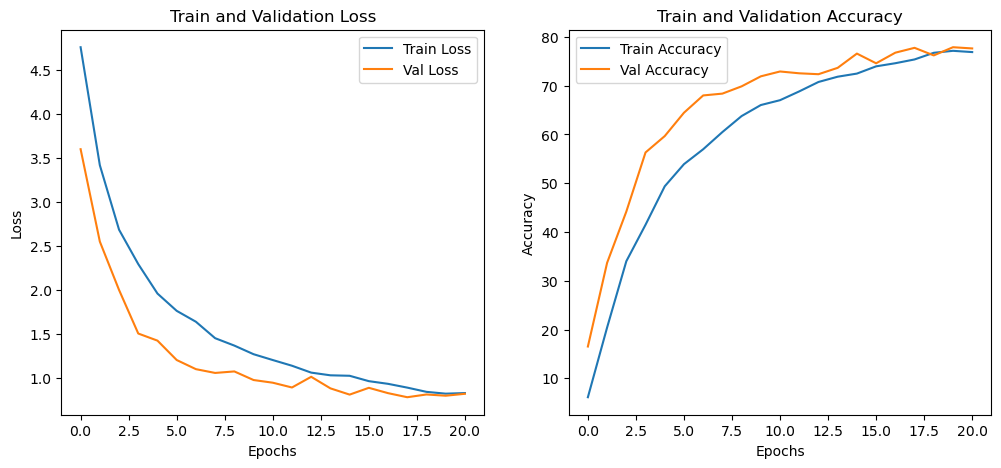

In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer_name = optimizer.__class__.__name__

# Initialize ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

if mlflow.active_run():
    mlflow.end_run()
with mlflow.start_run(run_name=architecture_description):
    # Log model parameters
    mlflow.log_param("model", "ResNet18")
    mlflow.log_param("optimizer", optimizer_name)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("use_cropped_images", True)
    mlflow.log_param("freeze_extractor_layers", False)
    mlflow.log_param("Dropout", dropout)
    mlflow.log_param("license_plate_blur", enable_plate_detection)
    mlflow.log_param("patience", patience)
    mlflow.log_param("use_augmentation", use_augmentation)

    best_val_loss = float('inf')
    wait = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Log metrics to MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch + 1)
        mlflow.log_metric("train_accuracy", train_accuracy, step=epoch + 1)
        mlflow.log_metric("val_loss", val_loss, step=epoch + 1)
        mlflow.log_metric("val_accuracy", val_accuracy, step=epoch + 1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
        # Step the scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        mlflow.log_metric("learning_rate", current_lr, step=epoch + 1)

        # Early stopping
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Final Test Phase
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Save confusion matrix as a DataFrame
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm_df.to_csv(confusion_metrics_path)

    # Log confusion matrix as an artifact
    mlflow.log_artifact(confusion_metrics_path, artifact_path="confusion_metrics")

    # Compute precision, recall, F1-score, and support for test set
    precision, recall, f1_score, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(len(class_names))
    )

    # Create a DataFrame to store test metrics
    test_metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Support': support
    })

    # Save test metrics to CSV
    test_metrics_df.to_csv(test_metrics_path, index=False)

    # Log test metrics DataFrame as an artifact
    mlflow.log_artifact(test_metrics_path, artifact_path="test_metrics")

    print("Test metrics and confusion matrix have been saved and logged to MLflow.")

    # Save and log the trained model as an artifact
    torch.save(model.state_dict(), model_save_path)  # Save locally for reference
    mlflow.log_artifact(model_save_path, artifact_path="models")  # Log the file as an artifact

    # Log the model directly to MLflow
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path="ResNet18-model",
    )

    # Plot training/validation loss and accuracy
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)


## Results <a class="anchor" id="fifth-bullet"></a>

#### Learning Curve

- **Train and Validation Loss:** Both curves decrease steadily and align closely, indicating effective learning and minimal overfitting.

- **Train and Validation Accuracy:** Both accuracies improve and converge around 75-80%, showing good generalization.

- **Conclusion**: The model demonstrates balanced training with no signs of overfitting or underfitting, achieving optimal performance for the given architecture and data.

<Figure size 800x600 with 0 Axes>

(-0.5, 1199.5, 499.5, -0.5)

Text(0.5, 1.0, 'Learning Curves')

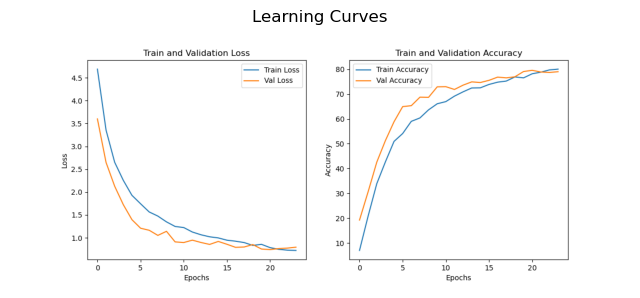

In [23]:
img = Image.open(learning_curves_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title("Learning Curves")
plt.show()


### Classification Metrics Analysis

The table below provides detailed insights into the precision, recall, F1-score, and support for each class. Below is an analysis of the overall trends observed across the metrics:

1. **F1-Score**:
   - The majority of the classes (151 out of 196, **approximately 77%**) are **well-predicted** with high F1-scores (> 0.7).
   - A small portion of the classes (8 out of 196, **approximately 4%**) **struggle significantly**, with F1-scores < 0.5.
   - This indicates that most classes have a good balance between precision and recall, while a few require further improvements.

2. **Precision**:
   - The majority of the classes (157 out of 196, **approximately 80%**) have **high precision** scores (> 0.7), indicating that the model makes accurate positive predictions for most classes.
   - A small portion of the classes (7 out of 196, **approximately 3.6%**) exhibit **poor precision** with scores < 0.5, suggesting challenges in avoiding false positives for these classes.

3. **Recall**:
   - Most classes (149 out of 196, **approximately 76%**) have high recall scores (> 0.7), showing the model's **ability to identify true positives effectively**.
   - However, a few classes (12 out of 196, **approximately 6.1%**) show recall scores < 0.5, indicating **difficulty in capturing all relevant instances for these classes**.

In [20]:
import seaborn as sns

# Read the classification metrics CSV file into a DataFrame
classification_metrics_df = pd.read_csv(test_metrics_path)
sorted_metrics_df = classification_metrics_df.sort_values(by="F1-Score", ascending=False)


print("Classification Metrics:")

sorted_metrics_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
)

Classification Metrics:


### Confusion Matrix

**Key Insights**
- 12 car classes with > 0.5 misclassification rate.

- Chevrolet Express Van 2007
    - Looking at the confusion matrix, 14 out of 28 images were classified as Chevrolet Express Cargo Van 2007, 13 out of 28 images were classified as GMC Savana Van 2012 and only once was correctly classified.

    - A Online Search revealed that the cars are visually very similar.


- Another example would be the Audi family of cars
    - Just between these 4 models: Audi TTS Coupe 2012, Audi TT Hatchback 2011, Audi TT RS Coupe 2012, Audi A5 Coupe 2012, Audi S5 Coupe 2012 there are already quite a number of misclassification with cars within the Audi Family

In [52]:
confusion_matrix_df = pd.read_csv(confusion_metrics_path, index_col=0)

# Calculate misclassification rates for each class
confusion_matrix = confusion_matrix_df.to_numpy()
misclassifications = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
misclassification_rate = misclassifications / confusion_matrix.sum(axis=1)

# Find the classes with the highest misclassification rates
most_misclassified = pd.DataFrame({
    "Class": confusion_matrix_df.index,
    "Misclassification Rate": misclassification_rate
}).sort_values(by="Misclassification Rate", ascending=False)

# Display the top 10 most misclassified classes
print(most_misclassified.head(12))


                                           Class  Misclassification Rate
70                    Chevrolet Express Van 2007                0.964286
73    Chevrolet Silverado 1500 Extended Cab 2012                0.823529
22                            Audi S4 Sedan 2012                0.741935
103                Ferrari 458 Italia Coupe 2012                0.735294
24                         Audi TT RS Coupe 2012                0.677419
12                            Audi A5 Coupe 2012                0.666667
176               Rolls-Royce Phantom Sedan 2012                0.628571
137                    Hyundai Sonata Sedan 2012                0.612903
183                        Suzuki SX4 Sedan 2012                0.593750
187                    Toyota Corolla Sedan 2012                0.588235
173               Ram C/V Cargo Van Minivan 2012                0.545455
68   Chevrolet Silverado 2500HD Regular Cab 2012                0.533333


In [53]:
# Identify the most misclassified pairs by finding the highest off-diagonal values
confusion_matrix_no_diag = confusion_matrix_df.copy()
# Set diagonal values to 0 to exclude correct classifications
for i in range(confusion_matrix_no_diag.shape[0]):
    confusion_matrix_no_diag.iloc[i, i] = 0

# Sort the misclassifications in descending order
misclassifications = confusion_matrix_no_diag.stack().reset_index()
misclassifications.columns = ['True_Label', 'Predicted_Label', 'Count']
misclassifications = misclassifications.sort_values(by='Count', ascending=False)

misclassifications.head(10)

True_Label  \
14361  Chevrolet Silverado 1500 Extended Cab 2012   
34671              Rolls-Royce Phantom Sedan 2012   
20290               Ferrari 458 Italia Coupe 2012   
16350                    Dodge Caliber Wagon 2007   
5915                BMW 6 Series Convertible 2007   
2373                           Audi A5 Coupe 2012   
13783                  Chevrolet Express Van 2007   
13838                  Chevrolet Express Van 2007   
28370                       Jeep Patriot SUV 2012   
26991                   Hyundai Sonata Sedan 2012   

                                     Predicted_Label  Count  
14361  Chevrolet Silverado 1500 Hybrid Crew Cab 2012     18  
34671                   Rolls-Royce Ghost Sedan 2012     18  
20290            Ferrari 458 Italia Convertible 2012     17  
16350                       Dodge Caliber Wagon 2012     15  
5915                         BMW M6 Convertible 2010     15  
2373                              Audi S5 Coupe 2012     14  
13783               Chevrolet Express Cargo Van 2007     14  
13838                            GMC Savana Van 2012     13  
28370                          Jeep Liberty SUV 2012     13  
26991                       Hyundai Azera Sedan 2012     12

In [45]:
# Ensure True_Label and Predicted_Label columns are strings
misclassifications['True_Label'] = misclassifications['True_Label'].astype(str)
misclassifications['Predicted_Label'] = misclassifications['Predicted_Label'].astype(str)

# Filter misclassifications for Audi cars
audi_misclassifications = misclassifications[
    (misclassifications['True_Label'].str.contains("Audi")) |
    (misclassifications['Predicted_Label'].str.contains("Audi"))
]

audi_misclassifications.head(20)

True_Label                   Predicted_Label  Count
2373               Audi A5 Coupe 2012                Audi S5 Coupe 2012     14
3541           Audi TT Hatchback 2011               Audi TTS Coupe 2012     10
4722            Audi TT RS Coupe 2012            Audi TT Hatchback 2011     10
2566              Audi TTS Coupe 2012            Audi TT Hatchback 2011     10
2956               Audi V8 Sedan 1994               Audi 100 Sedan 1994      9
4717            Audi TT RS Coupe 2012               Audi TTS Coupe 2012      8
4527               Audi S4 Sedan 2007                Audi S6 Sedan 2011      7
3348              Audi 100 Wagon 1994               Audi 100 Sedan 1994      6
4475               Audi S4 Sedan 2012  Mercedes-Benz E-Class Sedan 2012      5
4331               Audi S4 Sedan 2012                Audi S6 Sedan 2011      5
3153              Audi 100 Sedan 1994               Audi 100 Wagon 1994      4
2179       Audi RS 4 Convertible 2008                Audi S4 Sedan 2007      4
4333               Audi S4 Sedan 2012                Audi S5 Coupe 2012      4
4136               Audi S5 Coupe 2012          Audi S5 Convertible 2012      3
3355              Audi 100 Wagon 1994                Audi S4 Sedan 2007      3
3745               Audi S6 Sedan 2011                Audi S5 Coupe 2012      3
4325               Audi S4 Sedan 2012               Audi TTS Coupe 2012      3
37057  Volkswagen Golf Hatchback 2012               Audi TTS Coupe 2012      3
3347              Audi 100 Wagon 1994                Audi V8 Sedan 1994      3
3151              Audi 100 Sedan 1994                Audi V8 Sedan 1994      3

In [50]:
specific_audi_models=["Audi TTS Coupe 2012",
    "Audi TT Hatchback 2011",
    "Audi TT RS Coupe 2012",
    "Audi A5 Coupe 2012",
    "Audi S5 Coupe 2012"]
filtered_audi_misclassifications = audi_misclassifications[
    (audi_misclassifications['True_Label'].isin(specific_audi_models)) &
    (audi_misclassifications['Predicted_Label'].isin(specific_audi_models))
]
filtered_audi_misclassifications.head(10)


True_Label         Predicted_Label  Count
2373      Audi A5 Coupe 2012      Audi S5 Coupe 2012     14
3541  Audi TT Hatchback 2011     Audi TTS Coupe 2012     10
4722   Audi TT RS Coupe 2012  Audi TT Hatchback 2011     10
2566     Audi TTS Coupe 2012  Audi TT Hatchback 2011     10
4717   Audi TT RS Coupe 2012     Audi TTS Coupe 2012      8
2365      Audi A5 Coupe 2012     Audi TTS Coupe 2012      3
4128      Audi S5 Coupe 2012      Audi A5 Coupe 2012      2
2569     Audi TTS Coupe 2012      Audi S5 Coupe 2012      2
3552  Audi TT Hatchback 2011   Audi TT RS Coupe 2012      1
4129      Audi S5 Coupe 2012     Audi TTS Coupe 2012      1

## Post Training Analysis

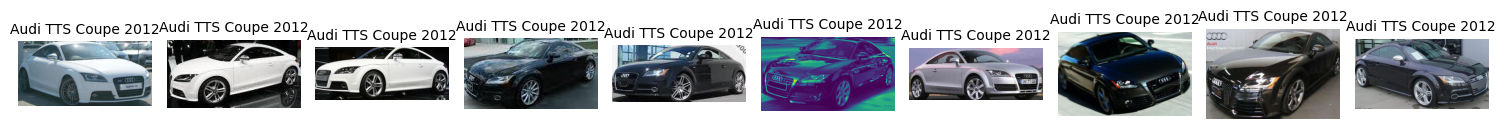

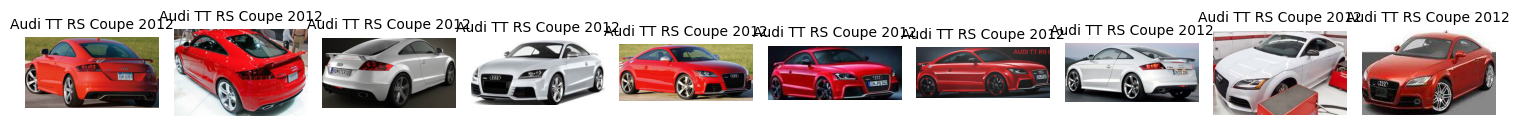

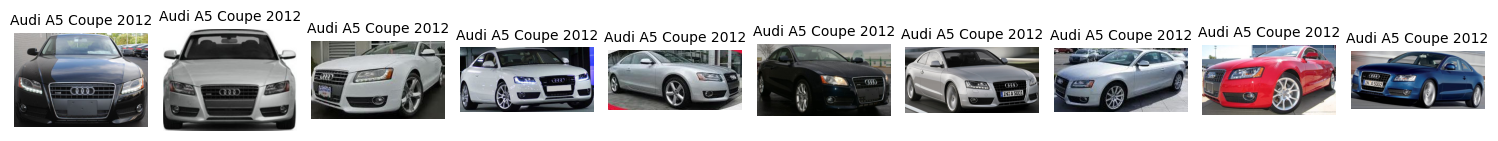

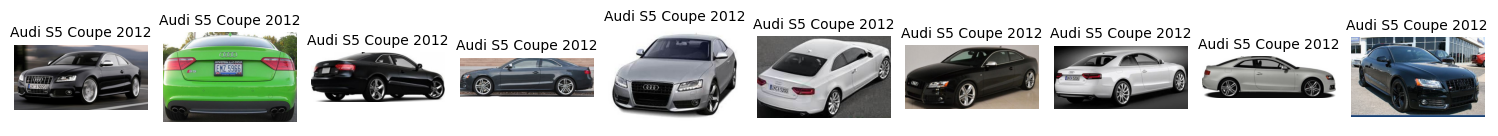

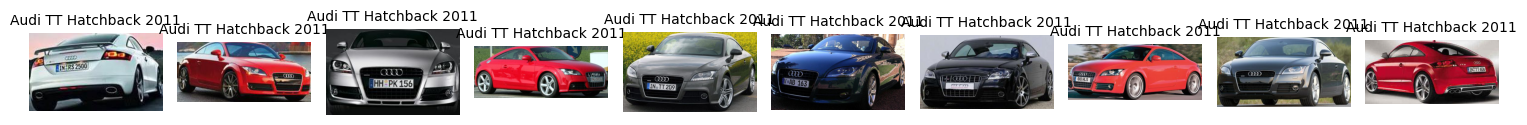

In [46]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import json

# Define the car models and their labels (update with your actual labels if available)
car_models = [
    "Audi TTS Coupe 2012",
    "Audi TT RS Coupe 2012",
    "Audi A5 Coupe 2012",
    "Audi S5 Coupe 2012",
    "Audi TT Hatchback 2011"
]

# Map class names to their respective labels
with open("class_names.json", "r") as f:
    class_names = json.load(f)
model_to_label = {model: class_names.index(model) for model in car_models}

# Function to plot images
def plot_car_samples(model_name, label, image_label_dict, image_dir, num_samples=5):
    """
    Plot a few samples of a specific car model from the dataset.
    Args:
        model_name (str): Name of the car model.
        label (int): Label corresponding to the car model.
        image_label_dict (dict): Dictionary of image file names and their labels.
        image_dir (Path): Path to the directory containing the images.
        num_samples (int): Number of samples to display.
    """
    # Filter images for the specific car model
    images = [img for img, lbl in image_label_dict.items() if lbl == label][:num_samples]

    # Display the images
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = image_dir / img_name
        with Image.open(img_path) as img:
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.title(f"{model_name}", fontsize=10)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Iterate over the specified car models and plot samples
for model_name, label in model_to_label.items():
    plot_car_samples(
        model_name=model_name,
        label=label,
        image_label_dict=training_image_label_dict,  # Use your training image-label dictionary
        image_dir=cropped_train_dir,  # Path to the training images
        num_samples=10
    )


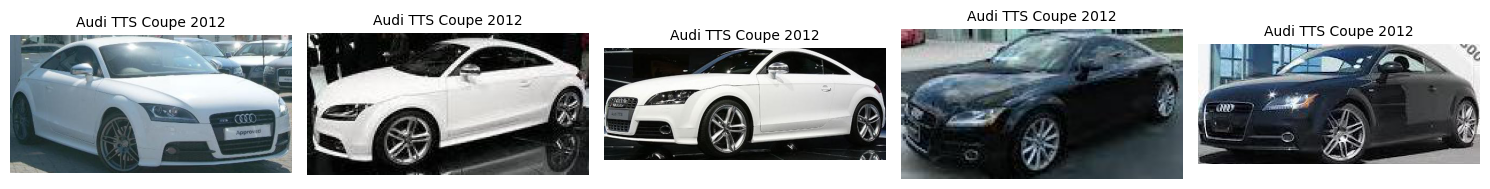

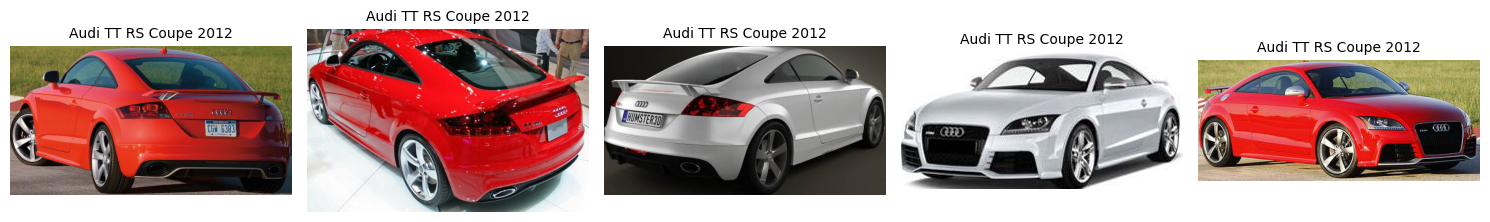

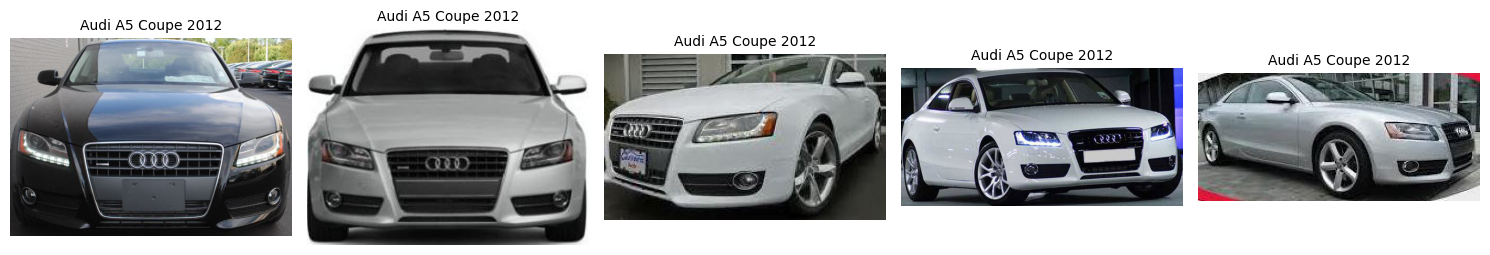

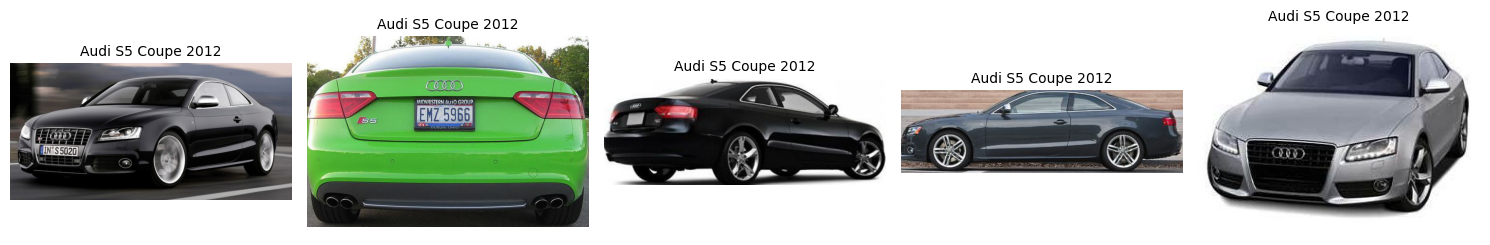

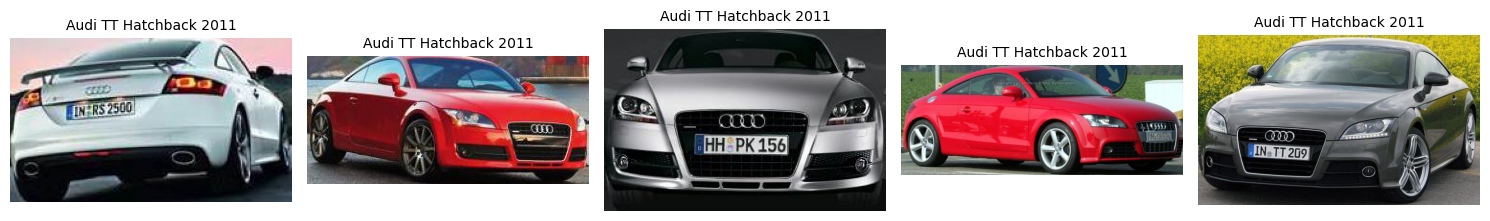

In [47]:
# Function to plot and save images
def plot_and_save_car_samples(model_name, label, image_label_dict, image_dir, output_dir, num_samples=5):
    """
    Plot and save a few samples of a specific car model from the dataset.
    
    Args:
        model_name (str): Name of the car model.
        label (int): Label corresponding to the car model.
        image_label_dict (dict): Dictionary of image file names and their labels.
        image_dir (Path): Path to the directory containing the images.
        output_dir (Path): Path to save the output images.
        num_samples (int): Number of samples to display.
    """
    # Filter images for the specific car model
    images = [img for img, lbl in image_label_dict.items() if lbl == label][:num_samples]
    
    # Ensure the output directory exists
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Display and save the images
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = image_dir / img_name
        with Image.open(img_path) as img:
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.title(f"{model_name}", fontsize=10)
            plt.axis("off")
            
            # Save the individual image
            output_path = output_dir / f"{model_name.replace(' ', '_')}_sample_{i + 1}.png"
            img.save(output_path)
    
    plt.tight_layout()
    
    # Save the full figure
    figure_path = output_dir / f"{model_name.replace(' ', '_')}_samples.png"
    plt.savefig(figure_path)
    plt.show()

# Example usage
output_dir = Path("data/output")  # Directory to save the output images

for model_name, label in model_to_label.items():
    plot_and_save_car_samples(
        model_name=model_name,
        label=label,
        image_label_dict=training_image_label_dict,  # Use your training image-label dictionary
        image_dir=cropped_train_dir,  # Path to the training images
        output_dir=output_dir,  # Path to save output images
        num_samples=5
    )
